In [3]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [4]:
DATA_PATH = "../data/raw_videos"

WORDS = ["loud", "quiet", "happy", "hot", "cold", "warm", "cool","new"]

SEQ_LEN = 30          # fixed frames per video
NUM_CLASSES = len(WORDS)

LABEL_MAP = {word: idx for idx, word in enumerate(WORDS)}


In [5]:
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.6
)

pose = mp_pose.Pose(min_detection_confidence=0.5)

In [6]:
def extract_landmarks(video_path):
    cap = cv2.VideoCapture(video_path)
    sequence = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        hand_results = hands.process(frame)
        pose_results = pose.process(frame)

        keypoints = []

        # ---- HANDS (2 hands × 21 points × (x,y)) ----
        for i in range(2):
            if hand_results.multi_hand_landmarks and i < len(hand_results.multi_hand_landmarks):
                for lm in hand_results.multi_hand_landmarks[i].landmark:
                    keypoints.extend([lm.x, lm.y])
            else:
                keypoints.extend([0] * 42)

        # ---- POSE (Upper body only) ----
        pose_ids = [11, 12, 13, 14, 15, 16]  # shoulders, elbows, wrists
        if pose_results.pose_landmarks:
            for idx in pose_ids:
                lm = pose_results.pose_landmarks.landmark[idx]
                keypoints.extend([lm.x, lm.y])
        else:
            keypoints.extend([0] * len(pose_ids) * 2)

        sequence.append(keypoints)

    cap.release()
    sequence = np.array(sequence)

    # ---- ADD MOTION (VELOCITY) FEATURES ----
    velocity = np.diff(sequence, axis=0)
    velocity = np.vstack([np.zeros((1, velocity.shape[1])), velocity])

    # Concatenate position + velocity
    sequence = np.concatenate([sequence, velocity], axis=1)
    return np.array(sequence)


In [7]:
def pad_sequence(seq, max_len=SEQ_LEN):
    if len(seq) >= max_len:
        return seq[:max_len]
    else:
        padding = np.zeros((max_len - len(seq), seq.shape[1]))
        return np.vstack((seq, padding))

In [8]:
X, y = [], []

for word in WORDS:
    folder = os.path.join(DATA_PATH, word)
    for video in os.listdir(folder):
        video_path = os.path.join(folder, video)

        sequence = extract_landmarks(video_path)
        sequence = pad_sequence(sequence)

        X.append(sequence)
        y.append(LABEL_MAP[word])

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, y.shape)

Dataset shape: (167, 30, 192) (167,)


In [9]:
from tensorflow.keras.utils import to_categorical
import numpy as np

NUM_CLASSES = 8

# y should be integers like: [0,0,0,1,1,1,2,2,...]
y = np.array(y)  

# Convert ONCE
y = to_categorical(y, NUM_CLASSES)

print(y.shape)   # ✅ (num_samples, 8)


(167, 8)


In [10]:
# X shape: (samples, frames, keypoints)
X = X.astype("float32")

# normalize per video
X = (X - X.mean(axis=1, keepdims=True)) / (
    X.std(axis=1, keepdims=True) + 1e-6
)

print("X:", X.shape)
print("y:", y.shape)


X: (167, 30, 192)
y: (167, 8)


In [24]:
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(SEQ_LEN, X.shape[2])),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),

    Bidirectional(LSTM(64)),

    Dense(64, activation='relu'),
    Dropout(0.6),

    Dense(NUM_CLASSES, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 28, 32)            18464     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 14, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 12, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 6, 64)            0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                      

In [25]:
history = model.fit(
    X, y,
    epochs=100,
    batch_size=4,
    validation_split=0.2,
    shuffle=True
)



Epoch 1/100
34/34 [==============================] - 6s 42ms/step - loss: 1.9889 - accuracy: 0.2406 - val_loss: 2.7400 - val_accuracy: 0.0000e+00
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 1.9005 - accuracy: 0.2857 - val_loss: 2.6801 - val_accuracy: 0.0000e+00
Epoch 3/100
34/34 [==============================] - 0s 12ms/step - loss: 1.6148 - accuracy: 0.3534 - val_loss: 3.4249 - val_accuracy: 0.0000e+00
Epoch 4/100
34/34 [==============================] - 0s 13ms/step - loss: 1.4201 - accuracy: 0.4361 - val_loss: 4.0858 - val_accuracy: 0.0000e+00
Epoch 5/100
34/34 [==============================] - 0s 11ms/step - loss: 1.2946 - accuracy: 0.5113 - val_loss: 4.2753 - val_accuracy: 0.0000e+00
Epoch 6/100
34/34 [==============================] - 0s 12ms/step - loss: 0.9947 - accuracy: 0.6165 - val_loss: 4.9398 - val_accuracy: 0.0000e+00
Epoch 7/100
34/34 [==============================] - 0s 13ms/step - loss: 0.8623 - accuracy: 0.6692 - val_loss: 4.5071 - val_

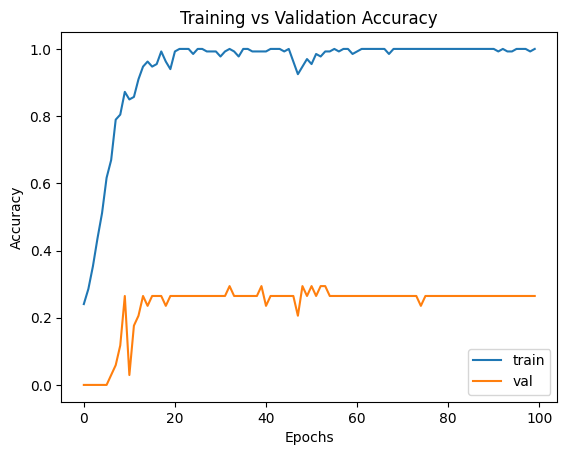

In [26]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()

In [35]:
preds = model.predict(X)
pred_classes = np.argmax(preds, axis=1)

import collections
collections.Counter(pred_classes)


6/6 [==============================] - 1s 4ms/step


Counter({1: 41, 3: 25, 0: 22, 2: 22, 5: 21, 4: 20, 6: 16})